# Identify Peaks by Derivative

In [3]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib
import re

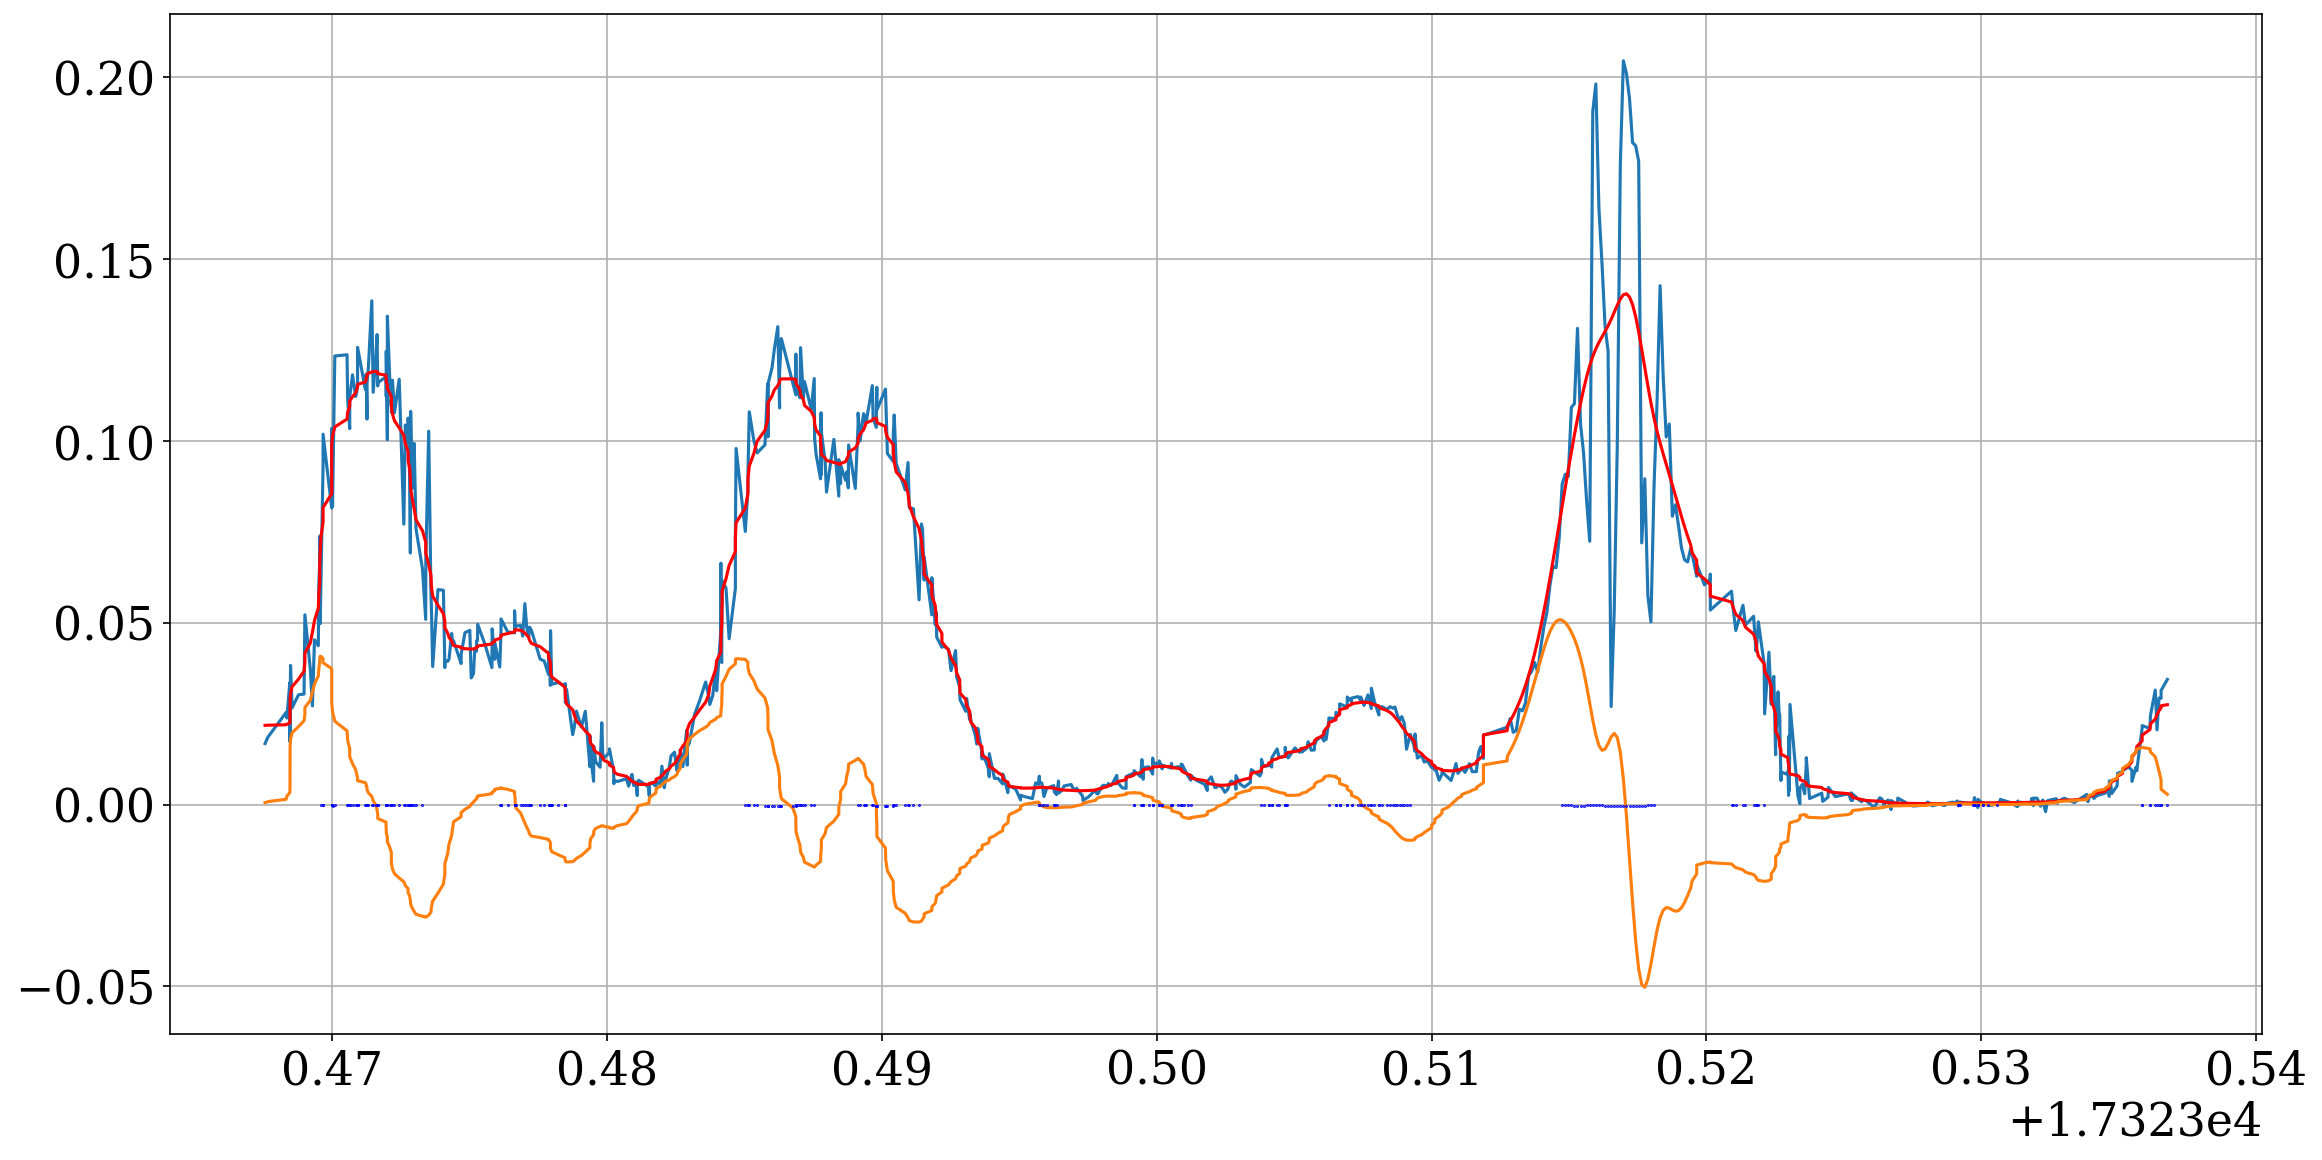

In [22]:
datafile = '20200428_scan2_unblocked_data.csv'
#datafile = '20200428_scan2_173_background_subtracted_data.csv'

k = np.genfromtxt(datafile, delimiter=',')[1:,1][:750]
a_nosmooth = np.genfromtxt(datafile, delimiter=',')[1:,2][:750]

# Smooth data, take derivative, smooth derivative, take derivative, smooth derivative

a = gaussian_filter1d(a_nosmooth, 5)

#a = savgol_filter(a_nosmooth, 33, 3)
da = np.gradient(a)
#da = savgol_filter(da, 5, 1)
dda = np.gradient(da)
dda = savgol_filter(dda, 25, 3)

fig, ax = plt.subplots(figsize=(18, 9),dpi=150)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

ax.plot(k, a_nosmooth)
ax.plot(k, a, 'r-')
ax.plot(k, da*10, markersize=.5)
ax.plot(k[dda<0], dda[dda<0], 'bo', markersize=.4)
ax.grid(True)
plt.show()

In [23]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [24]:
# Find peaks - |da| < threshold , dda < 0
threshold = .0005
peaks = []
for i in range(len(a)):
    if a[i] > .01 and abs(da[i]) < threshold and dda[i] < 0:
        peaks.append(i)
        
# Average nearby peak locations (could maybe get width from this)
runs = [[]]
for i in range(1,len(peaks)):
    if peaks[i] <= peaks[i-1]+8:
        runs[-1].append(peaks[i])
    else:
        runs.append([])
        runs[-1].append(peaks[i])


peaks = [int(mean(run)) for run in runs]
peak_widths = [.5*len(run)*(k[1]-k[0]) for run in runs] #Some ill-defined measure of uncertainty
k_peaks = np.array([k[i] for i in peaks])

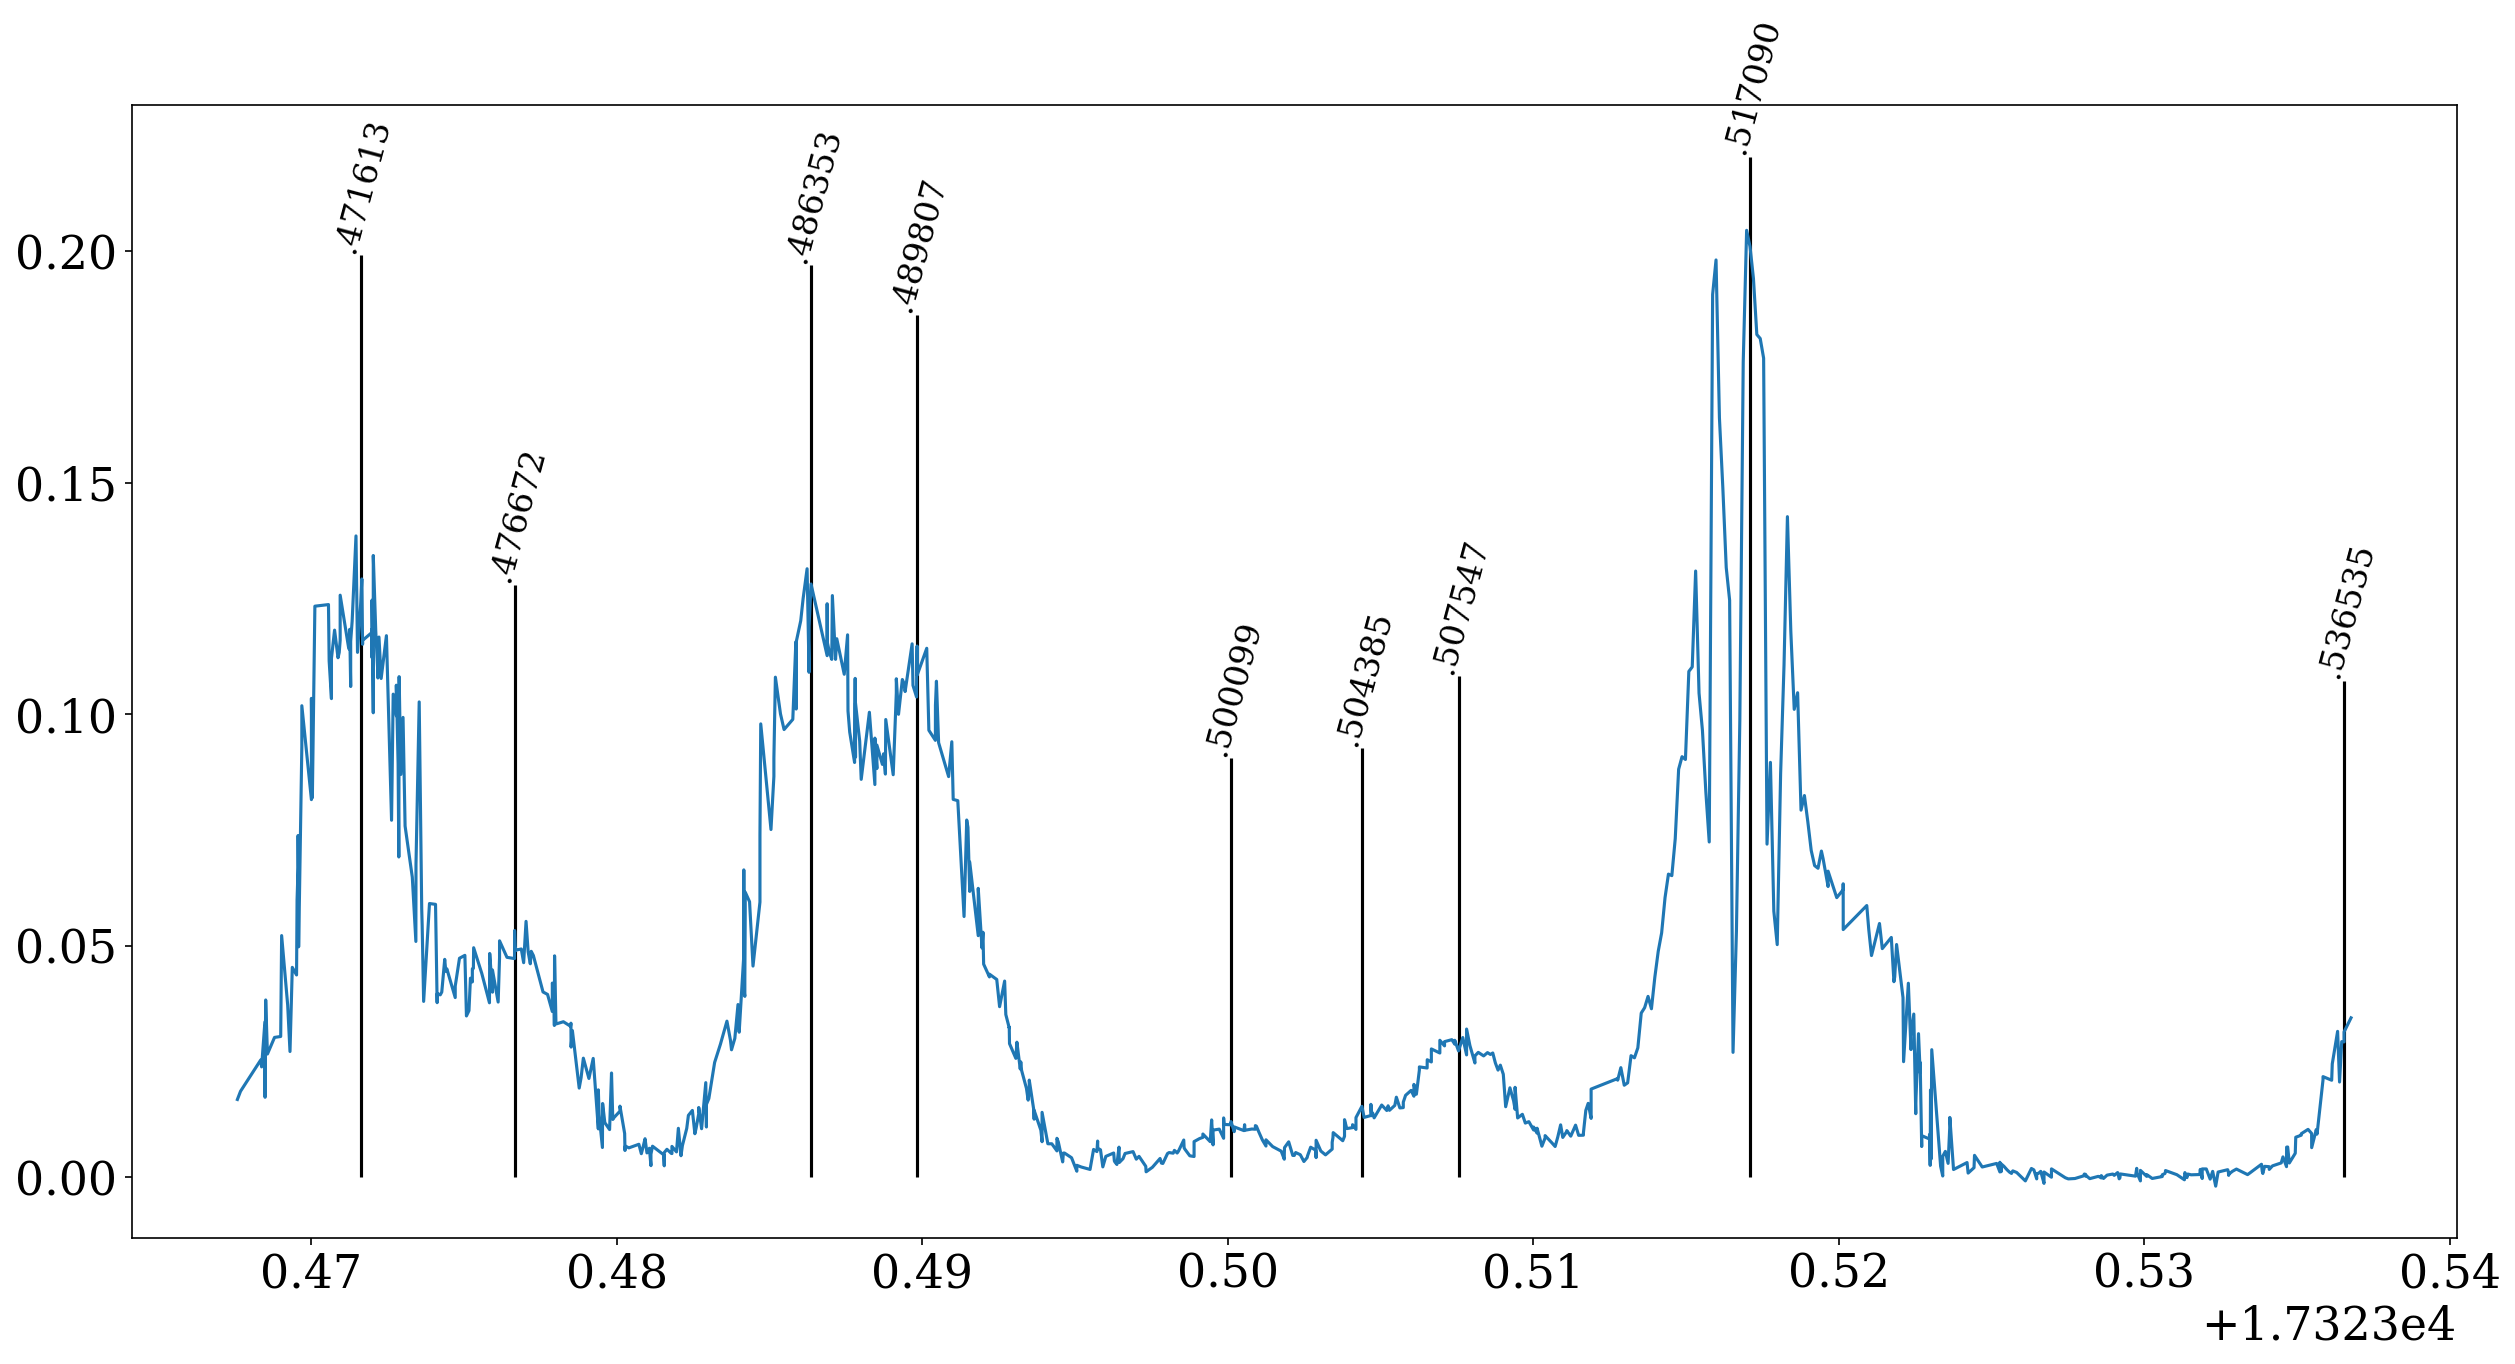

Line wavelengths: 0.47161356377546326, 0.47667248690413544, 0.4863533008210652, 0.4898073236727214, 0.5000993971298158, 0.5043855689982593, 0.5075476165256987, 0.5170902244208264, 0.5365355713984172
Line widths: 0.0004605936337611638, 0.0004605936337611638, 0.00020470828167162836, 0.00015353121125372127, 0.0005117707041790709, 0.0006653019154327922, 0.0007164789858506992, 5.117707041790709e-05, 0.00010235414083581418


In [20]:
fig, ax = plt.subplots(figsize=(20, 10),dpi=150)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

h = .22
ax.plot(k, a_nosmooth)

# Plot location and values of lines
for i in range(len(peaks)):
    ax.vlines(k[peaks[i]], 0, a[peaks[i]]+.08)
    
    ax.text(k[peaks[i]]-.001, 
            a[peaks[i]]+.08, str(k[peaks[i]]-int(k[0]))[1:8], 
            fontsize=16, rotation=75, va='bottom')

plt.show()

# Print the first 10 line to compare with Nick
print("Line wavelengths: " + ', '.join(map(str,k_peaks[:10]-int(k_peaks[0]))))
print("Line widths: " + ', '.join(map(str,peak_widths[:10])))  #Not working, should figure out how to do uncertainties

# Dataphile Fitting

In [6]:
# Generate model creator string
creator_string = ''

for i in peaks:
    creator_string += "Model(gaussian1D, Parameter(value={amplitude}, bounds=(.0001, .15),  label='amplitude'), Parameter(value={location}, bounds=(min(k), max(k)), label='center'),Parameter(value=.001,  bounds=(.0001, .01), label='width'), label='feature_{index}'),".format(location=k[i], amplitude=a[i], index=peaks.index(i))
creator_string += "label='gaussian_peaks')"
creator_string = "model = CompositeModel(" + creator_string


<IPython.core.display.Javascript object>


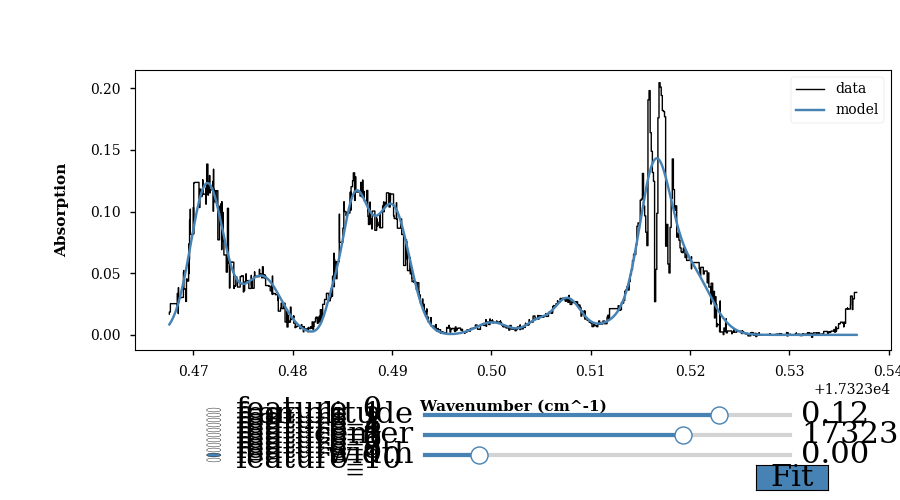

In [9]:
from dataphile.datasets import SyntheticDataset
from dataphile.statistics.distributions import gaussian1D, polynomial1D
from dataphile.statistics.regression.modeling import Parameter, Model, CompositeModel, AutoGUI
from matplotlib import patches
plt.style.use('seaborn-notebook')
%matplotlib notebook

figure = plt.figure('Absorption Data', figsize=(9, 5))

# create main plot of data
ax_1 = figure.add_axes([0.15, 0.14, 0.84, 0.70])
data_graph, = ax_1.step(k, a_nosmooth, color='black', lw=1, label='data')

# labels
ax_1.set_ylabel('Absorption', labelpad=15, fontweight='semibold')
ax_1.set_xlabel('Wavenumber (cm^-1)', labelpad=15, fontweight='semibold')


# overlay small markers showing location of features
#loc, yloc = x0_s, [(bias + peak).max() + 25 for peak in peaks]
#markers = ax_2.scatter(xloc, yloc, marker='v', color='steelblue')

exec(creator_string)

xsample = np.linspace(min(k), max(k), 1000)
model_graph, = ax_1.plot(xsample, model(xsample), color='steelblue', label='model')
ax_1.legend();

ax_1.set_position([0.15, 0.30, 0.84, 0.56])
gui = AutoGUI(model, [model_graph], bbox=[0.20, 0.07, 0.75, 0.12], figure=figure,
              slider_options={'color': 'steelblue'}, data=(k, a));


In [12]:
model.summary()

value  uncertainty
model      parameter                           
feature_0  amplitude      0.113285     0.002072
           center     17323.471428     0.000064
           width          0.001622     0.000047
feature_1  amplitude      0.041614     0.002807
           center     17323.476334     0.000212
           width          0.001839     0.000313
feature_2  amplitude      0.009808     0.022303
           center     17323.483858     0.013368
           width          0.002648     0.007931
feature_3  amplitude      0.117232     0.056524
           center     17323.486295     0.000059
           width          0.001278     0.000189
feature_4  amplitude      0.102307     0.017304
           center     17323.489958     0.000168
           width          0.001479     0.000093
feature_5  amplitude      0.010343     0.001850
           center     17323.500096     0.000364
           width          0.001369     0.000389
feature_6  amplitude      0.011841     0.004432
           center     17323.504483     0.000867
           width          0.001159     0.000644
feature_7  amplitude      0.029529     0.013497
           center     17323.507573     0.000327
           width          0.001258     0.000528
feature_8  amplitude      0.011720     0.021702
           center     17323.513206     0.013214
           width          0.002720     0.010489
feature_9  amplitude      0.114283     0.078915
           center     17323.516392     0.000216
           width          0.001465     0.000314
feature_10 amplitude      0.049595     0.014357
           center     17323.519487     0.000816
           width          0.001762     0.000431

[6.44038626e-05 2.11561344e-04 5.94035871e-05 1.68452877e-04
 3.27456775e-04 2.16029017e-04 8.16394064e-04]


<IPython.core.display.Javascript object>


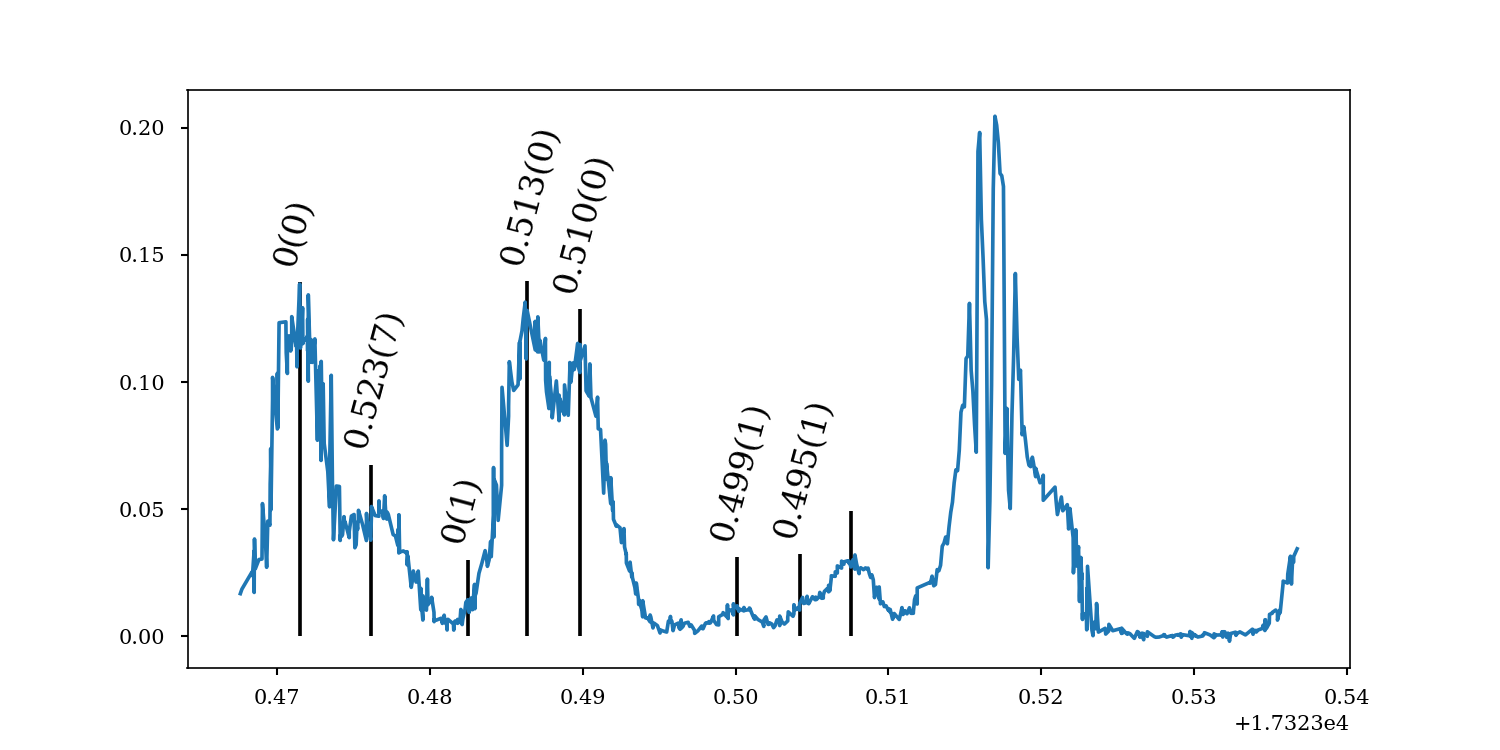

6.44038625913406e-05 0
0.00021156134385157281 4
5.940358714959595e-05 0
0.00016845287672999072 4
0.00032745677512887927 4
0.00021602901656003895 4
0.000816394063792437 4


IndexError: index 7 is out of bounds for axis 0 with size 7

In [17]:
values = np.array([i.values for i in model.models])
uncerts = np.array([i.uncertainties for i in model.models])

amplitudes = values[0:,0]
k_peaks = values[0:,1][amplitudes>.012]
d_k_peaks = uncerts[0:,1][amplitudes>.012]

print(d_k_peaks)

fig, ax = plt.subplots(figsize=(10, 5),dpi=150)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

h = .2
ax.plot(k, a_nosmooth)

# Plot location and values of lines
for i in range(len(peaks)):
    ax.vlines(k[peaks[i]], 0, a[peaks[i]]+.02)
    
    n = np.nonzero(list(map(int, re.findall('\d', str(d_k_peaks[i])))))[0][0]
    #if n==0: n = int(str(d_k_peaks[i])[-1])
    print(d_k_peaks[i],n)
    ax.text(k[peaks[i]]-.002, 
            a[peaks[i]]+.025, str(k[peaks[i]]-int(k[0]+1))[1:n+2]+'('+str(peak_widths[i])[n+2]+')', 
            fontsize=16, rotation=75, va='bottom')

plt.show()